In [1]:
import sys
import numpy as np
import gym
import ray
from ray.rllib.agents import ppo, a3c, cql, ddpg, dqn

gym.logger.set_level(40)

sys.path.append("..")

from source.envs.env import WhitedBasicModel
from source.solvers.ray_solver import RaySolver

%load_ext autoreload

A3C_Trainer = a3c.A3CTrainer
PPO_Trainer = ppo.PPOTrainer
DQNTrainer = dqn.DQNTrainer

In [2]:
ray.shutdown()
ray.init()
env = WhitedBasicModel(env_config={"structural_params": {"gamma": [0.9,0.96],
                                                         "delta": [0.1, 0.3],
                                                         "theta": [0.5, 0.8],
                                                         "rho": [0.3, 0.8],
                                                         "sigma": [0., 0.15],
                                                        }, 
                                   "env_params": {"psi_func": lambda i, k: 0.01*i**2/(2*k)
                                                 },
                                   "is_mutable": True,
                                  })
solver = RaySolver(env=env,
                   trainer=A3C_Trainer,
                   solver_params={"verbose": True, "episodes": 30,
                                  "trainer_config": {
                                      "num_workers": 8,
                                      "gamma": env.current_structural_params.get("gamma", 0.99),
                                  }
                                  })
solver.train()
ray.shutdown()

2022-01-04 15:36:20,245	INFO services.py:1340 -- View the Ray dashboard at http://127.0.0.1:8265
2022-01-04 15:36:21,299	INFO trainer.py:745 -- Current log_level is WARN. For more information, set 'log_level': 'INFO' / 'DEBUG' or use the -v and -vv flags.
2022-01-04 15:36:23,325	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
(RolloutWorker pid=48898) 2022-01-04 15:36:23,287	WARNING deprecation.py:46 -- DeprecationWarning: `convert_to_non_torch_type` has been deprecated. Use `ray/rllib/utils/numpy.py::convert_to_numpy` instead. This will raise an error in the future!
2022-01-04 15:36:23,342	WARNING util.py:57 -- Install gputil for GPU system monitoring.


agent_timesteps_total: 0
custom_metrics: {}
date: 2022-01-04_15-36-23
done: false
episode_len_mean: .nan
episode_media: {}
episode_reward_max: .nan
episode_reward_mean: .nan
episode_reward_min: .nan
episodes_this_iter: 0
episodes_total: 0
experiment_id: de2a1ccd1b864b29851daafb55a4f949
hostname: mw-14.local
info:
  learner:
    default_policy:
      batch_count: 10
      learner_stats:
        allreduce_latency: 0.0
        cur_lr: 0.0001
        entropy_coeff: 0.01
        grad_gnorm: 807.92919921875
        policy_entropy: 29.957077026367188
        policy_loss: -445.6387939453125
        vf_loss: 1364.88720703125
  num_steps_sampled: 10
  num_steps_trained: 10
iterations_since_restore: 1
node_ip: 127.0.0.1
num_healthy_workers: 8
off_policy_estimator: {}
perf:
  cpu_util_percent: 52.2
  ram_util_percent: 90.0
pid: 48860
policy_reward_max: {}
policy_reward_mean: {}
policy_reward_min: {}
sampler_perf: {}
time_since_restore: 0.055021047592163086
time_this_iter_s: 0.055021047592163086
ti

In [15]:
solver.trainer.save()

'/Users/mingweima/ray_results/A3C_my-env_2022-01-04_15-11-160hhhuamk/checkpoint_000030/checkpoint-30'

In [31]:
# run until episode ends
episode_reward = 0
done = False
obs = env.reset()
while not done:
    action = solver.act(obs)
    obs, reward, done, info = env.step(action, resample_param=False)
    episode_reward += reward
    print(obs, action, reward, done, info)

[1.26595008e+00 9.99950588e-01 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 8 0.5780609418282548 False {}
[1.60262966e+00 9.99243736e-01 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 8 0.6342507175787155 False {}
[2.02884912e+00 9.99478579e-01 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 8 0.688059452734865 False {}
[2.56842184e+00 9.99123633e-01 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 8 0.7384236772045981 False {}
[2.57559347e+00 9.99628723e-01 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 3 1.45656105511421 False {}
[3.26057267e+00 1.00016975e+00 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 8 0.7800528580714188 False {}
[3.26967692e+00 1.00030673e+00 9.46304286e-01 1.55102543e-01
 6.60192725e-01 6.19160279e-01 4.91249208e-04] 3 1.6672278643701115 False {}
[3.27880645e+00 9.99853015e-01 9.4630

In [50]:
"""Test trained agent for a single episode. Return the episode reward"""
cp = []
for eps in range(2):
      # instantiate env class
      episode_reward = 0
      done = False
      obs = env.reset()
      # run until episode ends
      caps = []
      while not done:
          action = solver.trainer.compute_single_action(obs, clip_action=True)
          obs, reward, done, info = env.step(action, resample_param=False)
          episode_reward += reward
          #print(action, obs, reward, done)
          caps += [obs[0]]
      cp += [ [caps] ]
cp = np.squeeze(np.array(cp)).mean(axis=0)

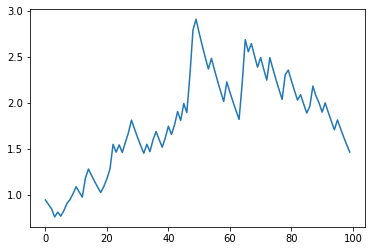

In [51]:
import matplotlib.pyplot as plt
plt.plot(cp)
plt.show()